### Single cell and flux tower calibrations

In [160]:
# Load required libraries and specify data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ---- Geospatial utilities
from geoUtils import *

calDataDir  = 'V:/PnET_SingleCells/FluxData/'
pnetSimsDir = 'V:/PnET_SingleCells/PinonJuniper/output/PNEToutputsites/eco0/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

### Read in some flux tower data
For the tower data, we need to cut up some monthly sums to match with the PnET output. Here, I am quickly doing some no-data flagging, and doing some aggregation by month, and sticking a new timestamp on the monthly sum dataframe for plotting and querying purposes. I also print out the column headers from the flux data.

In [161]:
tower_data = pd.read_csv(calDataDir + 'US-Mpj_daily_aflx.csv', sep = ',')

#Add a time stamp, set it as the index
tower_data.index = pd.to_datetime(tower_data.TS)
tower_data['year'] = tower_data.index.year
tower_data['month'] = tower_data.index.month

# Clean it up (Here, -9999 is 'no data')
tower_data[tower_data == -9999] = np.nan

# Take a monthly sum by year and month
monthlySum = tower_data.groupby([tower_data.year, tower_data.month]).sum().reset_index()

monthlyTS = pd.date_range(start='1/1/2008', end='7/31/2017', freq='MS')    
monthlySum.index = monthlyTS
monthlySum.columns

Index([u'year', u'month', u'GPP_g_int', u'RECO_g_int', u'FC_F_g_int',
       u'FC_F_g_nightint', u'FC_F_g_dayint', u'ET_mm_24hint_0', u'P_F_sum',
       u'TA_F_avg', u'RH_F_avg', u'SW_IN_F_avg', u'NETRAD_F_avg', u'VPD_F_avg',
       u'PPFD_IN_avg', u'LE_F_avg', u'H_F_avg', u'LE_F_int', u'H_F_int',
       u'TA_F_min', u'VPD_F_min', u'TA_F_max', u'VPD_F_max', u'ET_mm_dayint',
       u'PET_mm_dayint'],
      dtype='object')

### There are a lot of useful outputs here
but all I am going to focus on for now is the GPP and its components, as well as the bowen ratio in an effort to get a quick, flux perspective on surface soil moisture to udnersrtand how it relates to the surface C fluxes.

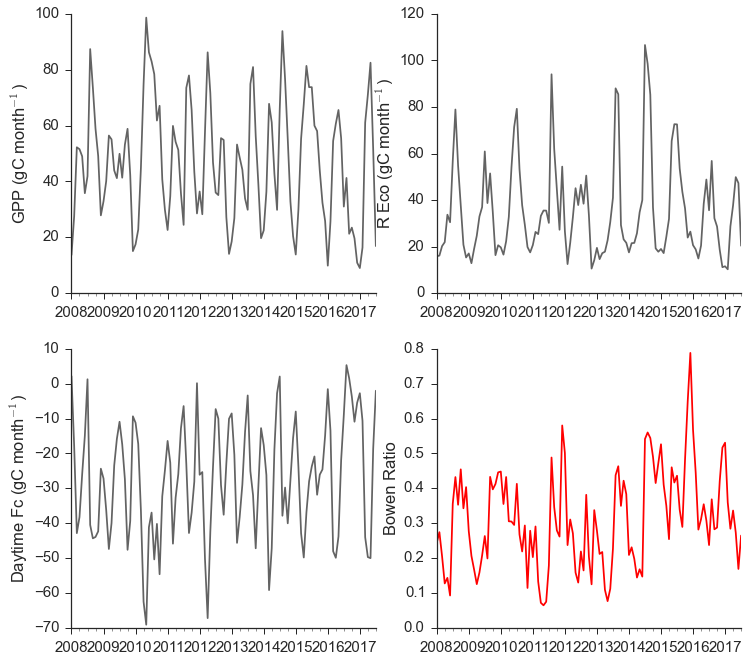

In [162]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize =(12,11))
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)

monthlySum.GPP_g_int.plot(ax = ax1, color = '#636363')
monthlySum.RECO_g_int.plot(ax = ax2, color = '#636363')
monthlySum.FC_F_g_dayint.plot(ax = ax3, color = '#636363')

# Calculate the bowen ratio
monthlySum['bowen'] = 1 / (1 + (monthlySum.H_F_int / monthlySum.LE_F_int))
monthlySum.bowen.plot(ax = ax4, color = 'red')

ax1.set_ylabel('GPP (gC month$^{-1}$)')
ax2.set_ylabel('R Eco (gC month$^{-1}$)')
ax3.set_ylabel('Daytime Fc (gC month$^{-1}$)')
ax4.set_ylabel('Bowen Ratio')



### Now we can take a quick peek at the PnET output
Again there are lots of outputs, and for the sake of simplicity I'm just looking at the C components here. We should also dig into water fluxes, LAI, and soil moisture. Here I read in the site output file, assign a meaningful index, add year and month columns, and select only the data that are relevant for our calibration. Also print out the column headers to see what all is currently output.

In [163]:
siteOutput = pd.read_csv(pnetSimsDir + 'Site.csv')
PnETmonthlyTS = pd.date_range(start='1/1/1800', end='12/31/2099', freq='MS')
siteOutput.index = PnETmonthlyTS
siteOutput['month'] = siteOutput.index.month
siteOutput['year'] = siteOutput.index.year

calOutput = siteOutput[(siteOutput.year >= 2008) & (siteOutput.year < 2018)]

calOutput = calOutput[calOutput.Time < 2017.58]
calOutput.columns

Index([u'Time', u'Ecoregion', u'SoilType', u'NrOfCohorts', u'MaxLayerStdev',
       u'Layers', u'PAR0', u'Tday(C)', u'Precip(mm/mo)', u'RunOff(mm/mo)',
       u'Leakage(mm)', u'PET(mm)', u'Evaporation(mm)', u'Transpiration(mm)',
       u'Interception(mm)', u'PrecLoss(mm/mo)', u'water(mm)',
       u'PressureHead(mm)', u'SnowPack(mm)', u'LAI(m2)', u'VPD(kPa)',
       u'GrossPsn(gC_m2_mo)', u'NetPsn(gC_m2_mo)',
       u'MaintenanceRespiration(gC_mo)', u'Wood(gDW)', u'Root(gDW)',
       u'Fol(gDW)', u'NSC(gC)', u'HeteroResp(gC_mo)', u'Litter(gDW_m2)',
       u'CWD(gDW_m2)', u'WoodSenescence(gDW_m2)', u'FoliageSenescence(gDW_m2)',
       u'SubCanopyPAR', u'month', u'year'],
      dtype='object')

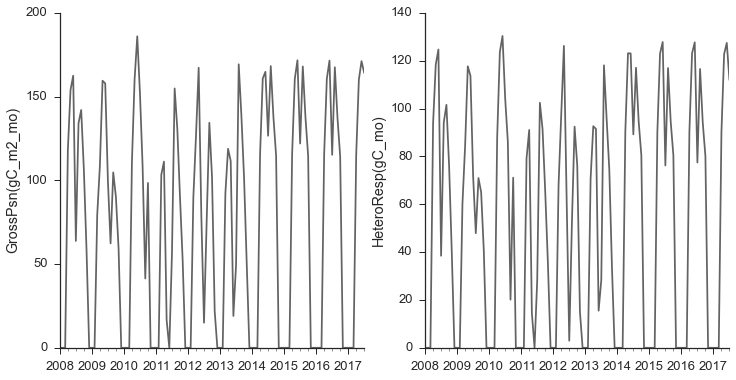

In [164]:
f, ((ax1, ax2)) = plt.subplots(1,2, figsize =(12,6))
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)

calOutput['GrossPsn(gC_m2_mo)'].plot(ax = ax1, color = '#636363')
calOutput['NetPsn(gC_m2_mo)'].plot(ax = ax2, color = '#636363')

ax1.set_ylabel('GrossPsn(gC_m2_mo)')
ax2.set_ylabel('HeteroResp(gC_mo)')


### To simplify stuff more, lets only look at the growing season
A cheap way of doing this is just to make the winter months in PnET the winter months at the flux tower site. That way when the ground is frozen, both PnET and the flux tower will accumulate zero C

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


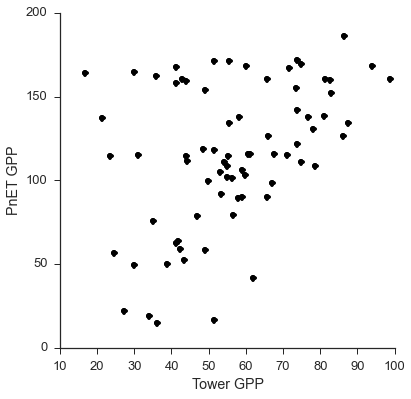

In [165]:
#Build a quick fit testing dataframe
monthlySum.GPP_g_int[calOutput['GrossPsn(gC_m2_mo)'] == 0] = np.nan
toFitGPP = pd.DataFrame(dict(tower = monthlySum.GPP_g_int, 
                             pnet = calOutput['GrossPsn(gC_m2_mo)'],
                             year = monthlySum.year,
                             month = monthlySum.month))

test = toFitGPP[toFitGPP.year <= 2013]

# quick linear fit funcs
def linfit(fitfunc, df):
    ols = smf.ols(fitfunc, df).fit()
    slope = (ols.params[1])
    intercept = (ols.params[0])
    return ols, slope, intercept

def plotLinFit(slope, intercept, Xmax, ax=None, *args, **kwargs):
    y = []
    if ax == None:
        ax = plt.gca()
    for num in np.arange(0, Xmax, 1):
         y.append(intercept + slope*num)
    ax.plot(np.arange(0, Xmax, 1), y,*args, **kwargs)

# Run the linear regression
fit, slope, intercept = linfit('tower~pnet', test)
    
f, (ax1) = plt.subplots(1,1, figsize =(6,6))
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)


ax1.plot(toFitGPP.tower, toFitGPP.pnet, 'ok')
ax1.set_xlabel('Tower GPP')
ax1.set_ylabel('PnET GPP')

In [166]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tower   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     29.45
Date:                Mon, 12 Mar 2018   Prob (F-statistic):           1.86e-06
Time:                        13:28:20   Log-Likelihood:                -201.55
No. Observations:                  50   AIC:                             407.1
Df Residuals:                      48   BIC:                             410.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.5666      4.987      6.329      0.000      21.539      41.595
pnet           0.2439      0.045      5.427      0.000       0.154       0.334
==============================================================================
Omnibus:                        0.832   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.519
Skew:                          -0.250   Prob(JB):                        0.771
Kurtosis:                       3.016   Cond. No.                         281.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""